In [120]:
import pandas as pd
import datetime
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

In [105]:
df = pd.read_csv('./train.csv')
df[:10]

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
5,2018-01-01 12:10:00+00:00,103.805858,29.177815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,20.305917,NaN,NaN,274.00,3.781696
6,2018-01-01 12:20:00+00:00,89.304200,28.871782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.00,18.093654,NaN,NaN,265.00,3.727462
7,2018-01-01 12:30:00+00:00,136.319172,28.531796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,27.029096,NaN,NaN,255.00,4.154484
8,2018-01-01 12:40:00+00:00,217.112015,28.344782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.00,43.690222,NaN,NaN,249.00,4.642134
9,2018-01-01 12:50:00+00:00,256.428119,28.244747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.00,51.545672,NaN,NaN,241.00,4.841759


In [144]:
df.shape, df.isna().sum()

((734, 19),
 ActivePower                     0
 AmbientTemperatue               0
 BearingShaftTemperature         0
 Blade1PitchAngle                0
 Blade2PitchAngle                0
 Blade3PitchAngle                0
 GearboxBearingTemperature       0
 GearboxOilTemperature           0
 GeneratorRPM                    0
 GeneratorWinding1Temperature    0
 GeneratorWinding2Temperature    0
 HubTemperature                  0
 MainBoxTemperature              0
 NacellePosition                 0
 ReactivePower                   0
 RotorRPM                        0
 TurbineStatus                   0
 WindDirection                   0
 WindSpeed                       0
 dtype: int64)

In [107]:
df = df.fillna(df.drop(columns=['Datetime']).mean())
df.isna().sum()

Datetime                        0
ActivePower                     0
AmbientTemperatue               0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

In [108]:
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.date
df = df.groupby(df['Datetime']).mean()
df.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,366.223561,25.528849,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,269.243261,74.042120,11.543193,2655.012634,269.243261,5.263797
2018-01-02,462.550740,25.357526,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,263.072199,93.555723,11.543193,2655.012634,263.072199,5.390719
2018-01-03,454.417752,24.379363,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,279.048569,91.627843,11.543193,2655.012634,279.048569,5.295225
2018-01-04,369.952190,24.912347,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,278.106921,74.360621,11.543193,2655.012634,278.106921,5.094994
2018-01-05,319.446595,23.535679,43.804575,3.099613,3.560774,3.560774,66.829573,58.94986,1286.548883,76.681186,76.02701,37.148869,39.192416,286.173749,64.366148,11.543193,2655.012634,286.173749,4.915224


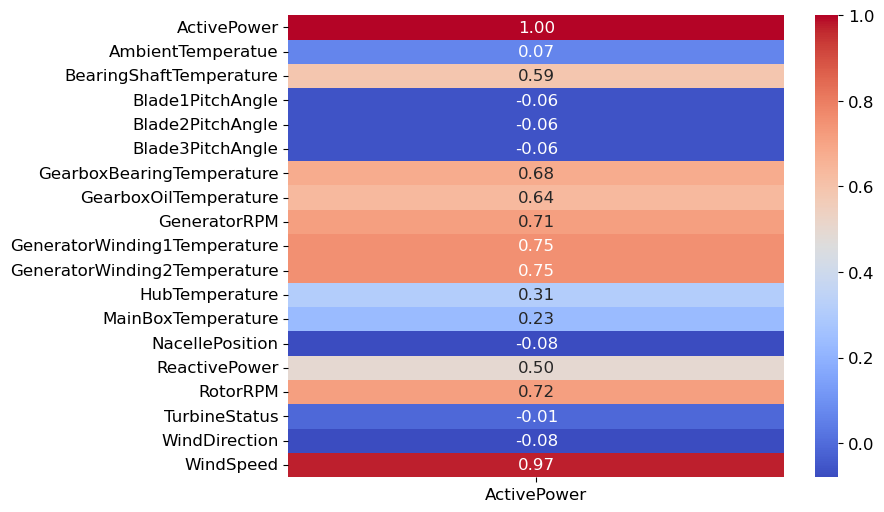

In [165]:
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['ActivePower']], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


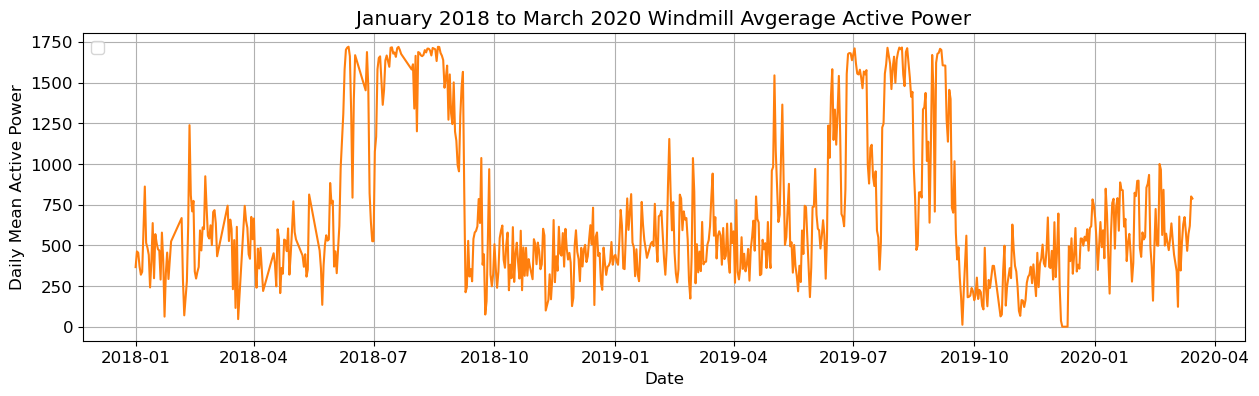

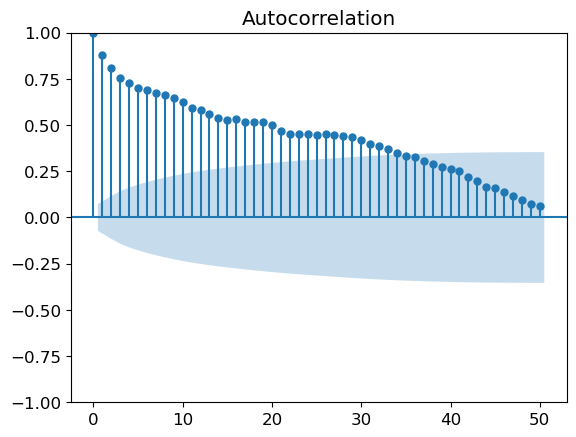

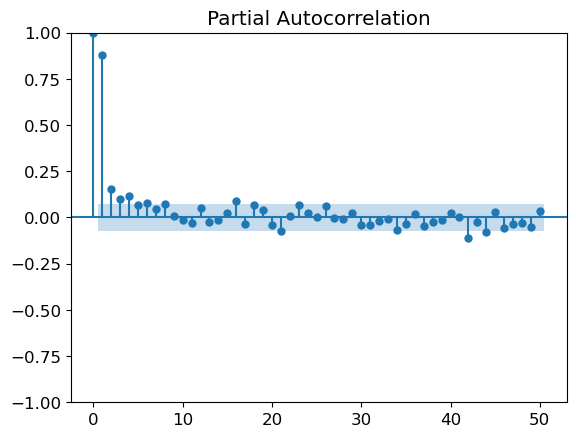


adf test p-value: 0.01792376595212781 ==> stationary


In [116]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df['ActivePower'], color='tab:orange')#, label='Daily Confirmed Case')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Active Power')
ax.set_title('January 2018 to March 2020 Windmill Avgerage Active Power')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
# ACF
plot_acf(df['ActivePower'],lags=50)
plt.show()
# PACF
plot_pacf(df['ActivePower'],lags=50)
plt.show()
# Dickey Fuller Test
adf_result = adfuller(df['ActivePower'], autolag="AIC")[1]
if adf_result <= 0.05:
    print(f'\nadf test p-value: {adf_result} ==> stationary')
else:
    print(f'\nadf test p-value: {adf_result} ==> non-stationary')

In [155]:
def evaluate_models_cv_exog(dataset, exog, p_values, d_values, q_values, P_values, D_values, Q_values, m, k):
    K=k
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=4
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(K):
                                train, test = dataset[0:train_size+k*validation_size], dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                train_x, test_x = exog[0:train_size+k*validation_size], exog[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, exog=train_x, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions=model_fit.predict(start=train_size+k*validation_size, end=train_size+(k+1)*validation_size-1, exog=test_x)
                                y_bar = test.mean(numeric_only=True)
                                rmse += np.sum(mean_squared_error(np.array(predictions), test)) / test.shape[0]
                            rmse_avg=rmse/K
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMAX%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMAX%s RMSE=%.3f' % (best_cfg, best_rmse))

In [170]:
p = range(0,9,3)
d = [0]
q = range(0,9,3)
P = range(0,9,3)
D = [0]
Q = range(0,9,3)
m = 12
k = 3
# 

evaluate_models_cv_exog(df['ActivePower'], df[['BearingShaftTemperature', 'RotorRPM', 'WindSpeed', 'ReactivePower']], p, d, q, P, D, Q, m, k)

SARIMAX[(0, 0, 0), (0, 0, 0, 12)] RMSE=649.592
SARIMAX[(0, 0, 0), (0, 0, 3, 12)] RMSE=590.188


KeyboardInterrupt: 

In [135]:
df['AmbientTemperatue']

Datetime
2018-01-01    25.528849
2018-01-02    25.357526
2018-01-03    24.379363
2018-01-04    24.912347
2018-01-05    23.535679
                ...    
2020-03-11    28.276232
2020-03-12    29.094133
2020-03-13    30.088163
2020-03-14    29.395626
2020-03-15    28.176449
Name: AmbientTemperatue, Length: 734, dtype: float64